### Cancer Detection Model

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Number of training images: 220025
Number of test images: 57458
Columns in test_df after filtering: Index(['id', 'label'], dtype='object')
Number of samples in test_df after filtering: 57458
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 797s 145ms/step - accuracy: 0.7753 - loss: 0.4807 - val_accuracy: 0.7748 - val_loss: 0.5159


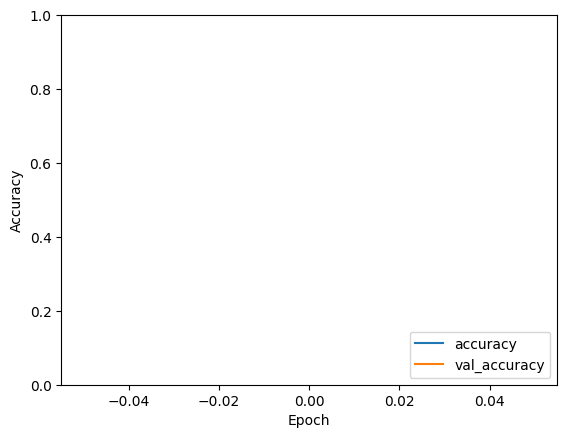

Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step
Prediction complete and saved to submission.csv


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
import multiprocessing
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import zipfile

# Force training on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load CSV file
test_df = pd.read_csv(os.path.expanduser("~/Desktop/pywork/sample_submission.csv"))

# Ensure .kaggle directory exists
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Ensure kaggle.json exists in the .kaggle directory
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
if not os.path.exists(kaggle_json_path):
    raise FileNotFoundError("kaggle.json file not found in .kaggle directory")

# Set Kaggle API environment variable
os.environ['KAGGLE_CONFIG_DIR'] = kaggle_dir

# Download the dataset
!kaggle competitions download -c histopathologic-cancer-detection -p .

with zipfile.ZipFile('histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('histopathologic-cancer-detection')

train_dir = "histopathologic-cancer-detection/train/"
test_dir = "histopathologic-cancer-detection/test/"

print("Number of training images: {}".format(len(os.listdir(train_dir))))
print("Number of test images: {}".format(len(os.listdir(test_dir))))

# Data preprocessing
train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

# Append '.tif' extension to the image IDs
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')
test_df['id'] = test_df['id'].apply(lambda x: x + '.tif')

# Ensure test filenames match the actual files in the directory
test_files = set(os.listdir(test_dir))
test_df = test_df[test_df['id'].isin(test_files)]

# Check the updated dataframe
print("Columns in test_df after filtering:", test_df.columns)
print("Number of samples in test_df after filtering:", len(test_df))

# Convert labels to strings
train_labels['label'] = train_labels['label'].astype(str)

# Splitting the data
train_df, valid_df = train_test_split(train_labels, stratify=train_labels['label'], test_size=0.2)

# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

# Building the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Training the model with fewer epochs (e.g., 5)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=1,  # Reduced number of epochs
    callbacks=[early_stopping, model_checkpoint]
)

# Plotting training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluating the model
model.load_weights('best_model.keras')
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator)
test_df['label'] = predictions
test_df.to_csv('submission.csv', index=False)
print("Prediction complete and saved to submission.csv")
